# EDA with Statistical test for Insurance binary classification

## *0-1* Importing Essential Packages

In [0]:
import pyarrow.csv as pv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2_contingency
import os
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from scipy import stats


sns.set_palette('pastel')
pastel_pallete = sns.color_palette('pastel')

mpl.rc('font', size=12)
mpl.rc('axes', titlesize=14)

## *0-2* Load Functions for preprocessing

In [1]:
# check numeric variable whether it is a float date type or int.
def float_or_int(num: pd.Series)-> pd.Series:
  if num.mod(1).eq(0).all(): # remainder divided by 1 is 0 means that it is a integer. 
    return num.astype('int')
  else:
    return num

# memory size reduction
def optimize_numeric(num: pd.Series)-> pd.Series:
  if pd.api.types.is_integer_dtype(num):
    num_min, num_max = num.min(), num.max()
    if (num_min >= 0) and (num_max <= np.iinfo(np.uint8).max):
      return num.astype(np.uint8)
    elif (num_min >= np.iinfo(np.int8).min) and (num_max <= np.iinfo(np.int8).max):
      return num.astype(np.int8)
    elif (num_min >= 0) and (num_max <= np.iinfo(np.int16).max):
      return num.astype(np.uint16)
    elif (num_min >= np.iinfo(np.int16).min) and (num_max <= np.iinfo(np.int16).max):
      return num.astype(np.int16)
    else:
      return pd.to_numeric(num, downcast='float')
  else:
    return pd.to_numeric(num, downcast='float')

# transforming origin data to new data
def optimize_data_types(data: dict) -> dict:
  orign = {}
  for name, df in data.items():
    initial_memory = df.memory_usage(deep=True).sum()
    initial_dtypes = df.dtypes.to_dict()

    update_df = df.copy()
    for col in df.columns:
      if pd.api.types.is_float_dtype(update_df[col]):
        update_df[col] = float_or_int(update_df[col])
      if pd.api.types.is_object_dtype(update_df[col]):
        update_df[col] = update_df[col].astype('category')
        orign[name+'_'+col] = update_df[col].cat.categories.to_list()
        update_df[col] = update_df[col].cat.codes
      if pd.api.types.is_bool_dtype(update_df[col]):
        update_df[col] = update_df[col].astype('int')
        
      update_df[col] = optimize_numeric(update_df[col])
      
    final_memory = update_df.memory_usage(deep=True).sum()
    final_dtypes = update_df.dtypes.to_dict()
    
    memory_reduction = (initial_memory - final_memory) / initial_memory * 100
    results = {
      'Initial Memory (Mb)' : initial_memory / 1024**2,
      'Final Memory (Mb)' : final_memory / 1024**2,
      'Memory Reduction (%)' : memory_reduction,
      'Dtype Changes' : [ (col, str(initial_dtypes[col]), str(final_dtypes[col]))
                         for col in df.columns]
    }
    print(f"DataFrame: {name}")
    print(f"Initial Memory Usage: {results['Initial Memory (Mb)']:.2f} MB")
    print(f"Final Memory Usage: {results['Final Memory (Mb)']:.2f} MB")
    print(f"Memory Reduction: {results['Memory Reduction (%)']:.2f}%")
    print("Dtype Changes:")
    for col, initial_dtype, final_dtype in results["Dtype Changes"]:
        print(f"  - {col}: {initial_dtype} -> {final_dtype}")
    print("\n")

    orign[name] = update_df

  return orign

In [2]:
def summary_table(data):
  print(f'The dimension of data set : {data.shape}')
  summary = pd.DataFrame({
    'Feature' : data.columns,
    'Data type' : data.dtypes,
    '# NAs' : data.isnull().sum(),
    'Mean' : np.round(data.mean(), 3),
    'Std' : np.round(data.std(), 3),
    "Min" : data.min(),
    "Max" : data.max(),
    '# uniques' : data.nunique(),
    "Mode" : data.mode().T[0]
  }).reset_index(drop=True)
  for idx, col in enumerate(data.columns):
    summary.loc[idx, '(%)'] = np.round(data[col].value_counts(normalize=True).iloc[0], 3)
  
  return summary

In [3]:
def write_percent(ax, total_size):
  for patch in ax.patches:
    height = patch.get_height()
    if height == 0:
      continue
    width = patch.get_width()
    left_coord = patch.get_x()
    percent = height/total_size * 100

    ax.text(x= left_coord + width / 2.0,
            y= height + total_size*0.003,
            s=f'{percent: 0.1f}%',
            ha='center')

In [4]:
# drawing count plot and bar plot for binary variables
def count_bar_graph(data: pd.DataFrame, binary_col: list, target: str):
  cols = 2
  rows = len(binary_col)
  ax = {}

  for idx, col in enumerate(binary_col):
    # countplot
    odd = idx % 2 + 1
    ax[odd] = plt.subplot(rows, cols, 2*idx+1)
    counts = data.groupby([col,target]).size().unstack().fillna(0)
    counts.plot(kind='bar', stacked=False, ax=ax[odd], color=pastel_pallete, edgecolor='none')
    ax[odd].set_title(f'{col} Distribution by {target}')
    ax[odd].set_ylabel('Frequency')
    plt.xticks(rotation=0)
    write_percent(ax[odd], len(data))

    # Barplot
    even = idx % 2
    ax[even] = plt.subplot(rows, cols, 2*(idx+1))
    means = data.groupby(col)[target].mean()
    std = data.groupby(col)[target].std()
    counts = data.groupby(col)[target].count()
    
    # 95% confidence interval
    std_err = std / np.sqrt(counts)
    conf_int = 1.96 * std_err
    
    means.plot(kind='bar', ax=ax[even], color=pastel_pallete[1], edgecolor='black', capsize=5)
    plt.errorbar(x = means.index,y= means.values, fmt='.', yerr=conf_int, color='black', capsize=5, label="Confidence Intervals")

    ax[even].set_title(f'Mean {target} by {col}')
    ax[even].set_ylabel(f'Mean {target}')
    for p in ax[even].patches:
      ax[even].text(p.get_x()+p.get_width() / 2, p.get_height() + 0.001, f'{p.get_height():.4f}', ha='center')
 
    plt.xticks(rotation=0)

  plt.tight_layout()
  plt.show()

In [5]:
# drawing count plot and bar plot for binary variables
def count_bar_graph_vert(data: pd.DataFrame, binary_col: list, target: str):
  cols = len(binary_col)
  rows = 2
  ax = {}

  for idx, col in enumerate(binary_col):
    # countplot
    odd = idx % 2 + 1
    ax[odd] = plt.subplot(rows, cols, 2*idx+1)
    counts = data.groupby([col,target]).size().unstack().fillna(0)
    counts.plot(kind='bar', stacked=False, ax=ax[odd], color=pastel_pallete, edgecolor='none')
    ax[odd].set_title(f'{col} Distribution by {target}')
    ax[odd].set_ylabel('Frequency')
    plt.xticks(rotation=0)
    for p in ax[odd].patches:
      if p.get_height() == 0:
        continue
      ax[odd].text(p.get_x()+p.get_width() / 2, p.get_height() + 0.001, f'{p.get_height()/len(data) * 100:.1f}%', ha='center', rotation=45)
    
    # Barplot
    even = idx % 2
    ax[even] = plt.subplot(rows, cols, 2*(idx+1))
    means = data.groupby(col)[target].mean()
    std = data.groupby(col)[target].std()
    counts = data.groupby(col)[target].count()
    
    # 95% confidence interval
    std_err = std / np.sqrt(counts)
    conf_int = 1.96 * std_err
    
    means.plot(kind='bar', ax=ax[even], color=pastel_pallete[1], edgecolor='black', capsize=5)
    plt.errorbar(x = means.index,y= means.values, fmt='.', yerr=conf_int, color='black', capsize=5, label="Confidence Intervals")

    ax[even].set_title(f'Mean {target} by {col}')
    ax[even].set_ylabel(f'Mean {target}')
    for p in ax[even].patches:
      ax[even].text(p.get_x()+p.get_width() / 2, p.get_height() + 0.007, f'{p.get_height():.4f}', ha='center', rotation=45)
  
    plt.xticks(rotation=0)

  plt.tight_layout()
  plt.show()

In [6]:
# calculating Cramers V values for two nominal variables
def cramers_v(df: pd.DataFrame, bin_cols: list, target: str):
  bin_col = bin_cols.copy()
  bin_col.append(target)
  cramers_v_mat = pd.DataFrame(index=bin_col, columns=bin_col, dtype='float')
  for var1 in bin_col:
    for var2 in bin_col:
      if var1 == var2:
        cramers_v_mat.loc[var1, var2] = 1
      else:
        contingency_table = pd.crosstab(df[var1], df[var2])
        chi2, _, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        cramers_vs = np.sqrt(phi2 / min(r - 1, k - 1))
        cramers_v_mat.loc[var1, var2] = cramers_vs
  return cramers_v_mat

## *1-1* Importing Data sets

In [7]:
file_path = '/home/kar7mp5/Projects/2024-Binary-Classification-of-Insurance-Cross-Selling'
file_name = ['train.csv','test.csv','sample_submission.csv']

train_table = pv.read_csv(os.path.join(file_path, file_name[0])).drop(['id'])
test_table = pv.read_csv(os.path.join(file_path, file_name[1])).drop(['id'])
sub_table = pv.read_csv(os.path.join(file_path, file_name[2]))
display(sub_table.to_pandas().head())

FileNotFoundError: [Errno 2] Failed to open local file '/home/kar7mp5/Downloads/playground-series-s4e7/train.csv'. Detail: [errno 2] No such file or directory

In [ ]:
dataframes = {'train': train_table.to_pandas(), 'test': test_table.to_pandas()}
optimized_dataframes = optimize_data_types(dataframes)

DataFrame: train
Initial Memory Usage: 2484.70 MB
Final Memory Usage: 197.49 MB
Memory Reduction: 92.05%
Dtype Changes:
  - Gender: object -> uint8
  - Age: int64 -> uint8
  - Driving_License: int64 -> uint8
  - Region_Code: float64 -> float32
  - Previously_Insured: int64 -> uint8
  - Vehicle_Age: object -> uint8
  - Vehicle_Damage: object -> uint8
  - Annual_Premium: float64 -> float32
  - Policy_Sales_Channel: float64 -> uint8
  - Vintage: int64 -> uint16
  - Response: int64 -> uint8


DataFrame: test
Initial Memory Usage: 1597.95 MB
Final Memory Usage: 102.40 MB
Memory Reduction: 93.59%
Dtype Changes:
  - Gender: object -> uint8
  - Age: int64 -> uint8
  - Driving_License: int64 -> uint8
  - Region_Code: float64 -> uint8
  - Previously_Insured: int64 -> uint8
  - Vehicle_Age: object -> uint8
  - Vehicle_Damage: object -> uint8
  - Annual_Premium: float64 -> float32
  - Policy_Sales_Channel: float64 -> uint8
  - Vintage: int64 -> uint16




In [ ]:
train = optimized_dataframes.pop('train')
test = optimized_dataframes.pop('test')

In [ ]:
train.shape, test.shape

((11504798, 11), (7669866, 10))

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                uint8  
 1   Age                   uint8  
 2   Driving_License       uint8  
 3   Region_Code           float32
 4   Previously_Insured    uint8  
 5   Vehicle_Age           uint8  
 6   Vehicle_Damage        uint8  
 7   Annual_Premium        float32
 8   Policy_Sales_Channel  uint8  
 9   Vintage               uint16 
 10  Response              uint8  
dtypes: float32(2), uint16(1), uint8(8)
memory usage: 197.5 MB
None


In [ ]:
display(train.describe().T)

,count,mean,std,min,25%,50%,75%,max
Gender,11504798.0,0.541351,0.498287,0.0,0.0,1.0,1.0,1.0
Age,11504798.0,38.383563,14.993459,20.0,24.0,36.0,49.0,85.0
Driving_License,11504798.0,0.998022,0.044431,0.0,1.0,1.0,1.0,1.0
Region_Code,11504798.0,26.418718,12.991590,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11504798.0,0.462997,0.498629,0.0,0.0,0.0,1.0,1.0
Vehicle_Age,11504798.0,0.521530,0.576739,0.0,0.0,0.0,1.0,2.0
Vehicle_Damage,11504798.0,0.502680,0.499993,0.0,0.0,1.0,1.0,1.0
Annual_Premium,11504798.0,30461.359375,16454.744141,2630.0,25277.0,31824.0,39451.0,540165.0
Policy_Sales_Channel,11504798.0,112.425442,54.035708,1.0,29.0,151.0,152.0,163.0
Vintage,11504798.0,163.897744,79.979531,10.0,99.0,166.0,232.0,299.0


## *1-2* Check Irregular Data

In [ ]:
# summary of the train data set
summary_table(data=train)

The dimension of data set : (11504798, 11)


,Feature,Data type,# NAs,Mean,Std,Min,Max,# uniques,Mode,(%)
0,Gender,uint8,0,0.541,0.498,0.0,1.0,2,1.0,0.541
1,Age,uint8,0,38.384,14.993,20.0,85.0,66,24.0,0.071
2,Driving_License,uint8,0,0.998,0.044,0.0,1.0,2,1.0,0.998
3,Region_Code,float32,0,26.419,12.992,0.0,52.0,54,28.0,0.300
4,Previously_Insured,uint8,0,0.463,0.499,0.0,1.0,2,0.0,0.537
5,Vehicle_Age,uint8,0,0.522,0.577,0.0,2.0,3,0.0,0.520
6,Vehicle_Damage,uint8,0,0.503,0.500,0.0,1.0,2,1.0,0.503
7,Annual_Premium,float32,0,30461.359,16454.744,2630.0,540165.0,51728,2630.0,0.184
8,Policy_Sales_Channel,uint8,0,112.425,54.036,1.0,163.0,152,152.0,0.362
9,Vintage,uint16,0,163.898,79.980,10.0,299.0,290,187.0,0.009


In [ ]:
# check the Region_Code variable
train['Region_Code'].unique() # 39.2...?

array([35. , 28. , 14. ,  1. , 15. , 47. , 45. ,  8. , 11. ,  3. , 10. ,
       12. , 37. , 50. , 30. , 46. , 29. , 16. , 26. , 25. , 41. , 48. ,
        7. ,  4. , 24. , 36. , 33. ,  2. ,  9. , 27. , 18. , 43. , 49. ,
       17. , 13. , 38. ,  6. , 21. , 23. ,  0. , 19. ,  5. , 39. , 44. ,
       20. , 40. , 22. , 32. , 42. , 31. , 34. , 51. , 52. , 39.2],
      dtype=float32)

In [ ]:
# check the outlier, 39.2
display(train[train['Region_Code']==39.2])

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
11370234,0,20,1,39.200001,1,1,0,2630.0,159,74,0


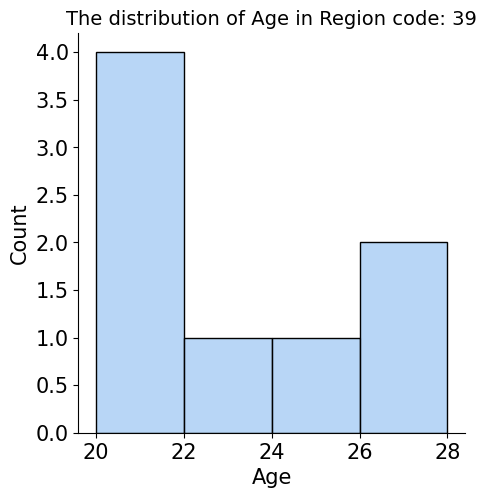

In [ ]:
# the main key common factor is Policy_Sales_Channel, since its large multiple classes
mpl.rc('font', size=15)
sns.displot(train.loc[(train['Region_Code']==39.0) & (train['Policy_Sales_Channel']==159), 'Age'])
plt.title(f'The distribution of Age in Region code: 39')
plt.show()

In [ ]:
display(train[(train['Region_Code']==39.0)&(train['Policy_Sales_Channel']==159)&(train['Gender']==0)])

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
4140172,0,26,1,39.0,0,1,1,2630.0,159,244,0
6132602,0,24,1,39.0,1,1,0,2630.0,159,229,0
8103998,0,21,1,39.0,0,1,1,34221.0,159,185,0
10709419,0,20,1,39.0,0,1,1,27683.0,159,32,0


In [ ]:
# therefore, put the 39.2 code to 39.0
train.loc[train["Region_Code"]==39.2, 'Region_Code'] = 39.0

train['Region_Code'] = train['Region_Code'].astype(np.uint8)
print(f'the final memory is : {train.memory_usage(deep=True).sum()/1024**2:.2f} MB')
tmp_table = summary_table(train)
display(tmp_table)
display(summary_table(test))

the final memory is : 164.58 MB
The dimension of data set : (11504798, 11)


,Feature,Data type,# NAs,Mean,Std,Min,Max,# uniques,Mode,(%)
0,Gender,uint8,0,0.541,0.498,0.0,1.0,2,1.0,0.541
1,Age,uint8,0,38.384,14.993,20.0,85.0,66,24.0,0.071
2,Driving_License,uint8,0,0.998,0.044,0.0,1.0,2,1.0,0.998
3,Region_Code,uint8,0,26.419,12.992,0.0,52.0,53,28.0,0.300
4,Previously_Insured,uint8,0,0.463,0.499,0.0,1.0,2,0.0,0.537
5,Vehicle_Age,uint8,0,0.522,0.577,0.0,2.0,3,0.0,0.520
6,Vehicle_Damage,uint8,0,0.503,0.500,0.0,1.0,2,1.0,0.503
7,Annual_Premium,float32,0,30461.359,16454.744,2630.0,540165.0,51728,2630.0,0.184
8,Policy_Sales_Channel,uint8,0,112.425,54.036,1.0,163.0,152,152.0,0.362
9,Vintage,uint16,0,163.898,79.980,10.0,299.0,290,187.0,0.009


The dimension of data set : (7669866, 10)


,Feature,Data type,# NAs,Mean,Std,Min,Max,# uniques,Mode,(%)
0,Gender,uint8,0,0.541,0.498,0.0,1.0,2,1.0,0.541
1,Age,uint8,0,38.391,15.000,20.0,85.0,66,24.0,0.071
2,Driving_License,uint8,0,0.998,0.044,0.0,1.0,2,1.0,0.998
3,Region_Code,uint8,0,26.427,12.994,0.0,52.0,53,28.0,0.300
4,Previously_Insured,uint8,0,0.463,0.499,0.0,1.0,2,0.0,0.537
5,Vehicle_Age,uint8,0,0.522,0.577,0.0,2.0,3,0.0,0.520
6,Vehicle_Damage,uint8,0,0.503,0.500,0.0,1.0,2,1.0,0.503
7,Annual_Premium,float32,0,30465.523,16445.865,2630.0,540165.0,50044,2630.0,0.183
8,Policy_Sales_Channel,uint8,0,112.365,54.074,1.0,163.0,151,152.0,0.362
9,Vintage,uint16,0,163.900,79.984,10.0,299.0,290,187.0,0.009


## *1-3* Modified Values of Data

In [ ]:
orign_code = optimized_dataframes
display(orign_code)

{'train_Gender': ['Female', 'Male'],
 'train_Vehicle_Age': ['1-2 Year', '< 1 Year', '> 2 Years'],
 'train_Vehicle_Damage': ['No', 'Yes'],
 'test_Gender': ['Female', 'Male'],
 'test_Vehicle_Age': ['1-2 Year', '< 1 Year', '> 2 Years'],
 'test_Vehicle_Damage': ['No', 'Yes']}

In [ ]:
# re-allocating ordered variable, Vehicle_Age : < 1 Year -> 1-2 Year -> > 2 Years
train['Vehicle_Age'] = train['Vehicle_Age'].replace({0: 1, 1: 0})
test['Vehicle_Age'] = test['Vehicle_Age'].replace({0: 1, 1: 0})

In [ ]:
# split column types
binary_cols = [col for col in tmp_table.loc[tmp_table['# uniques']==2, 'Feature'] if col != 'Response']
ord_col = ["Vehicle_Age"]
num_cols = [col for col in tmp_table.loc[tmp_table['(%)'] < 0.2, 'Feature']]
cat_cols = [col for col in tmp_table.loc[(tmp_table['# uniques'] > 50)&(tmp_table['(%)'] > 0.2), 'Feature']]

print("The Variables :", "\n", f"Binary variables : {binary_cols}", "\n", f"Ordered variable : {ord_col}", "\n", f"Numeric variables : {num_cols}", "\n", f"Categorical variables : {cat_cols}")

The Variables : 
 Binary variables : ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage'] 
 Ordered variable : ['Vehicle_Age'] 
 Numeric variables : ['Age', 'Annual_Premium', 'Vintage'] 
 Categorical variables : ['Region_Code', 'Policy_Sales_Channel']


## *2* EDA

### *2-0* Target distribution

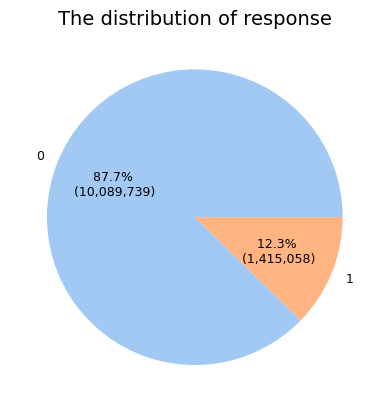

In [ ]:
target = train['Response'].value_counts()
mpl.rc('font', size=9)
plt.pie(target, labels=target.index, autopct=lambda p: f'{p: .1f}% \n ({int(p * sum(target) / 100):,})')
plt.title(f'The distribution of response')
plt.show()

## *2-1* Numeric Variables' Distribution

In [ ]:
# check the duplicated data
duplicated_rows1 = train.duplicated(keep=False)
print(train[duplicated_rows1])
duplicated_rows2 = train.iloc[:, :-2].duplicated(keep=False)
print(train[duplicated_rows2])
duplicated_rows3 = test.duplicated(keep=False)
print(test[duplicated_rows3])

Empty DataFrame
Columns: [Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
          Gender  Age  Driving_License  Region_Code  Previously_Insured  \
2              0   25                1           14                   1   
3              0   35                1            1                   0   
5              0   31                1           47                   1   
6              1   23                1           45                   1   
8              0   26                1           28                   1   
...          ...  ...              ...          ...                 ...   
11504791       0   31                1           32                   1   
11504794       0   26                1           36                   0   
11504795       0   29                1           32                   1   
11504796       0   51                1           28              

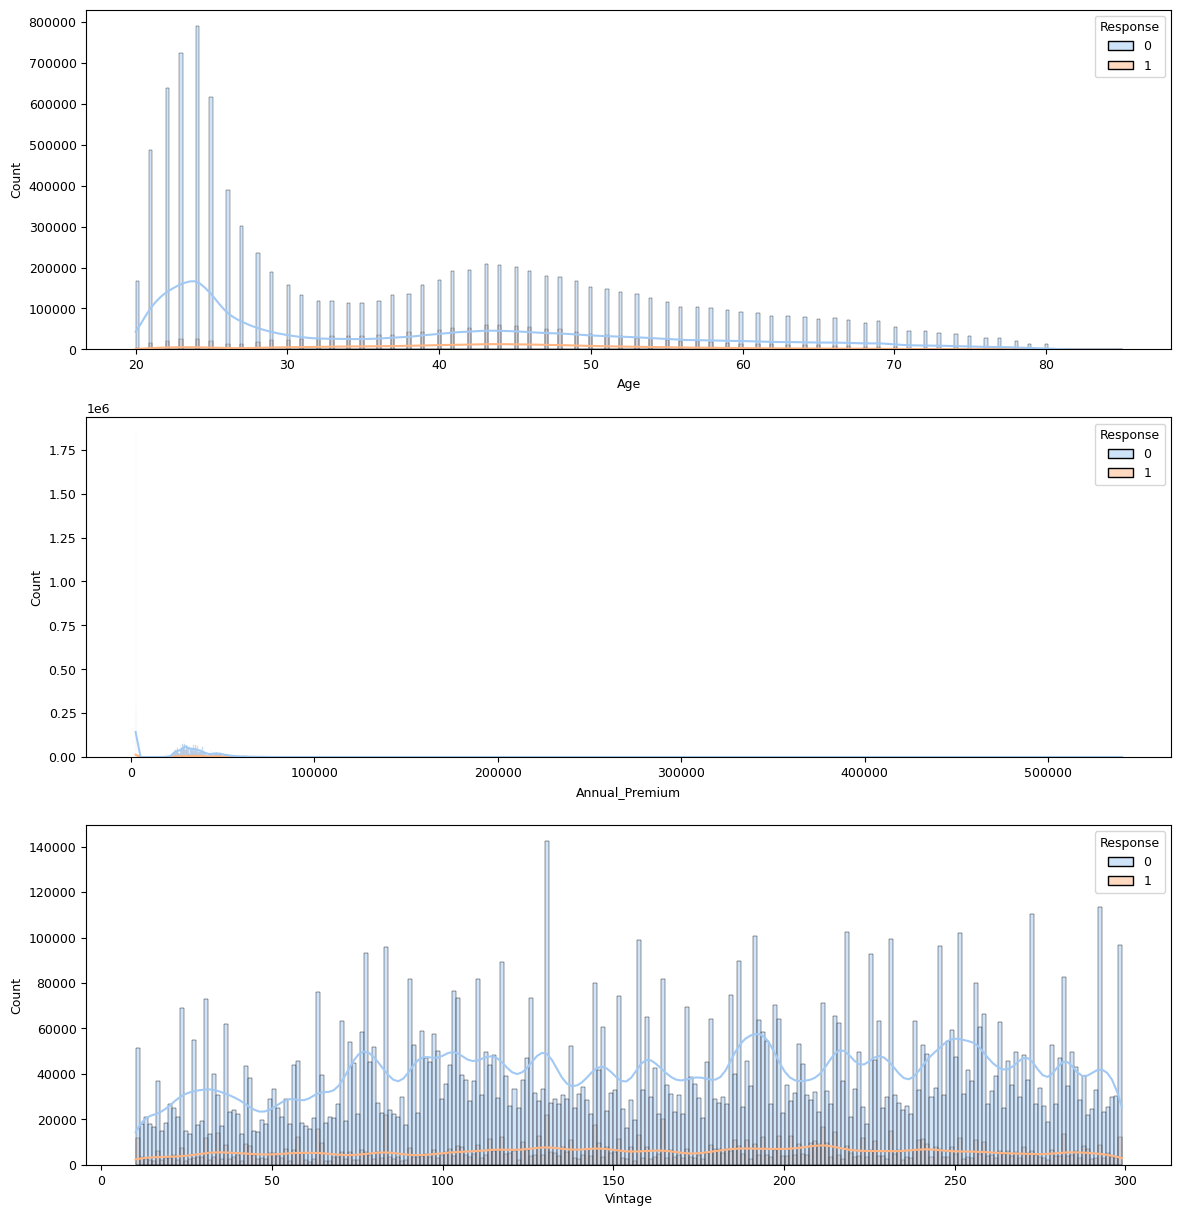

In [ ]:
# plot histogram with target distribution
fig, ax = plt.subplots(len(num_cols),ncols=1, figsize=(14,15))
for idx, col in enumerate(num_cols):

  # histogram
  sns.histplot(train, x=col, hue='Response', kde=True, ax=ax[idx])

plt.show()


In [ ]:
# plot boxplot with target distribution
# fig, ax = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(16,7))
# for idx, col in enumerate(num_cols):

#   # boxplot
#   sns.boxplot(train, y=col, hue='Response', ax=ax[idx])

# plt.show()


In [ ]:
norm_sc_age = StandardScaler()
norm_sc_vin = StandardScaler()
med_sc_prem = RobustScaler()
mms_ord = MinMaxScaler()
train_tmp = train[num_cols+['Response']].copy()
test_tmp = test[num_cols].copy()

In [ ]:
# print(sum(np.log(train_tmp['Age'])) / len(train_tmp['Age']))
# np.log(train_tmp['Age']).quantile([0., 0.25, .5, .75, 1.])

In [ ]:
train_tmp['Age'] = np.log(train_tmp['Age'])
test_tmp['Age'] = np.log(test_tmp['Age'])

# # plot histogram and boxplot with target distribution
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# # histogram
# sns.histplot(tmp, x='Age', hue='Response', kde=True, ax=ax[0])

# # boxplot
# sns.boxplot(tmp, y='Age', hue='Response', ax=ax[1])

# plt.show()

In [ ]:
train_tmp['Age'] = norm_sc_age.fit_transform(train_tmp[['Age']])
test_tmp['Age'] = norm_sc_age.transform(test_tmp[['Age']])

# # plot histogram and boxplot with target distribution
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# # histogram
# sns.histplot(tmp, x='Age', hue='Response', kde=True, ax=ax[0])

# # boxplot
# sns.boxplot(tmp, y='Age', hue='Response', ax=ax[1])

# plt.show()

In [ ]:
train_tmp['Vintage'] = norm_sc_vin.fit_transform(train_tmp[['Vintage']])
test_tmp['Vintage'] = norm_sc_vin.transform(test_tmp[['Vintage']])

# # plot histogram and boxplot with target distribution
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# # histogram
# sns.histplot(tmp, x='Vintage', hue='Response', kde=True, ax=ax[0])

# # boxplot
# sns.boxplot(tmp, y='Vintage', hue='Response', ax=ax[1])

# plt.show()

In [ ]:
train_tmp['Annual_Premium_box'], _ = stats.boxcox(train_tmp['Annual_Premium']/1000)
test_tmp['Annual_Premium_box'], _ = stats.boxcox(test_tmp['Annual_Premium']/1000)

# # plot histogram and boxplot with target distribution
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# # histogram
# sns.histplot(tmp, x='Annual_Premium_box', hue='Response', kde=True, ax=ax[0])

# # boxplot
# sns.boxplot(tmp, y='Annual_Premium_box', hue='Response', ax=ax[1])

# plt.show()

In [ ]:
train_tmp['Annual_Premium'] = med_sc_prem.fit_transform(train_tmp[['Annual_Premium_box']])/10
test_tmp['Annual_Premium'] = med_sc_prem.transform(test_tmp[['Annual_Premium_box']])/10

# # plot histogram and boxplot with target distribution
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# # histogram
# sns.histplot(tmp, x='Annual_Premium', hue='Response', kde=True, ax=ax[0])

# # boxplot
# sns.boxplot(tmp, y='Annual_Premium', hue='Response', ax=ax[1])

# plt.show()

In [ ]:
train[num_cols] = train_tmp[num_cols]
test[num_cols] = test_tmp[num_cols]

In [ ]:
# To consider the order, let Vehicle_Age as a numeric variable
train[ord_col] = mms_ord.fit_transform(train[ord_col])
test[ord_col] = mms_ord.transform(test[ord_col])

### *2-2* Sampling

In [ ]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,-1.375977,1,35,0,0.5,1,0.222867,124,0.288852,0
1,1,0.490723,1,28,0,1.0,1,0.182874,26,1.551675,1
2,0,-0.923340,1,14,1,0.0,0,0.043386,152,1.126566,0
3,0,-0.048584,1,1,0,0.5,1,-0.229486,156,-1.099003,0
4,0,0.027771,1,15,1,0.5,0,0.000897,152,1.626694,0


In [ ]:
means = train.groupby(['Vehicle_Age'])['Response'].mean()
display(cramers_v(train, ['Vehicle_Age'], "Response"))

# plt.figure(figsize=(10, 8))
# mpl.rc('font', size=12)
# ax = means.plot(kind='bar', color=pastel_pallete[1], edgecolor='black')
# for idx in range(len(means)):
#   plt.text(idx, means[idx]+0.005, round(means[idx], 2), ha='center', va='bottom')
# plt.plot(means.index, means.values, marker='o', linestyle='-')
# plt.xlabel('Vehicle_Age : ordinal variable')
# plt.ylabel('Mean of Response')
# plt.xticks(rotation=0)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

,Vehicle_Age,Response
Vehicle_Age,1.000000,0.231162
Response,0.231162,1.000000


In [ ]:
# re-define variables, with considering order
print(train.columns)
cluster_cols = binary_cols + cat_cols + ['Response']
# calculate_cols = num_cols + ord_col

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [ ]:
def process_column(train, col, cluster_cols):
    # means
    means = train.groupby(cluster_cols)[col].mean().reset_index()
    
    # 100 percentiles
    quantiles = np.linspace(0, 1,21)
    quantile_values = (train.groupby(cluster_cols)[col]
                       .apply(lambda x: x.quantile(quantiles))
                       .drop_duplicates()
                       .reset_index()
                       .drop('level_7', axis=1))
    
    # merging
    result = pd.concat([means, quantile_values], axis=0)
    
    return result.drop_duplicates()

In [ ]:
df_age = process_column(train, 'Age', cluster_cols)
df_premium = process_column(train, 'Annual_Premium', cluster_cols)
df_vintage = process_column(train, 'Vintage', cluster_cols)
df_vehicle = process_column(train, 'Vehicle_Age', cluster_cols)

In [ ]:
result_dfs = [df_age, df_premium, df_vintage, df_vehicle]
reduced_train = result_dfs[0]

for df in result_dfs[1:]:
  reduced_train = pd.merge(reduced_train, df, on=cluster_cols, how='outer')

In [ ]:
reduced_train.shape

(4357612, 11)

In [ ]:
train[train['Response']==1].groupby(cluster_cols)['Response'].sum().sum()
  

1415059

In [ ]:
reduced_train['Response'].value_counts()

Response
0    3293136
1    1064476
Name: count, dtype: int64

In [ ]:
reduced_train.isnull().sum()

Gender                  0
Driving_License         0
Previously_Insured      0
Vehicle_Damage          0
Region_Code             0
Policy_Sales_Channel    0
Response                0
Age                     0
Annual_Premium          0
Vintage                 0
Vehicle_Age             0
dtype: int64

In [ ]:
# row permutation
permuted_indices = np.random.permutation(reduced_train.index)
train_modified = reduced_train.reindex(permuted_indices).reset_index(drop=True)

In [ ]:
# column re-arrange
train_modified = pd.concat([train_modified.drop(['Response'], axis=1)[test.columns], train_modified['Response']], axis=1)
display(train_modified.head())
train_modified.shape

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,0.866504,1,46,1,0.500000,1,-0.020600,21,0.001279,0
1,0,1.549561,0,15,0,0.519231,1,0.085619,14,0.413884,0
2,0,0.932617,0,28,1,0.500000,0,-0.036654,25,-0.118752,0
3,0,0.438574,1,47,0,0.500000,1,-0.015846,23,-0.680146,0
4,0,1.056836,1,32,0,0.300000,0,-0.051848,154,0.885255,0


(4357612, 11)

In [ ]:
# for training model, let categorical variable as categorical data type
train_modified[cat_cols] = train_modified[cat_cols].astype('category')
display(train_modified.head())
train_modified.info()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,0.866504,1,46,1,0.500000,1,-0.020600,21,0.001279,0
1,0,1.549561,0,15,0,0.519231,1,0.085619,14,0.413884,0
2,0,0.932617,0,28,1,0.500000,0,-0.036654,25,-0.118752,0
3,0,0.438574,1,47,0,0.500000,1,-0.015846,23,-0.680146,0
4,0,1.056836,1,32,0,0.300000,0,-0.051848,154,0.885255,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357612 entries, 0 to 4357611
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                uint8   
 1   Age                   float64 
 2   Driving_License       uint8   
 3   Region_Code           category
 4   Previously_Insured    uint8   
 5   Vehicle_Age           float64 
 6   Vehicle_Damage        uint8   
 7   Annual_Premium        float64 
 8   Policy_Sales_Channel  category
 9   Vintage               float64 
 10  Response              uint8   
dtypes: category(2), float64(4), uint8(5)
memory usage: 166.2 MB


### *2-3* Feature Engineering

In [ ]:
cramers_v(train_modified, binary_cols,'Response')

,Gender,Driving_License,Previously_Insured,Vehicle_Damage,Response
Gender,1.000000,0.168557,0.108467,0.072466,0.024660
Driving_License,0.168557,1.000000,0.075611,0.183226,0.223371
Previously_Insured,0.108467,0.075611,1.000000,0.212507,0.216112
Vehicle_Damage,0.072466,0.183226,0.212507,1.000000,0.123135
Response,0.024660,0.223371,0.216112,0.123135,1.000000


In [ ]:
conti_table = pd.crosstab(train_modified['Driving_License'], train_modified['Response'])
chi2, p, _, _ = chi2_contingency(conti_table)
print(chi2, p)

217420.49009474542 0.0


In [ ]:
tmp_test1 = train_modified['Driving_License']*train_modified['Previously_Insured']
tmp_test2 = train_modified['Driving_License']+train_modified['Previously_Insured']
tmp_test3= train_modified['Driving_License'].astype(str) + train_modified['Previously_Insured'].astype(str)

In [ ]:
conti_table1 = pd.concat([tmp_test1, tmp_test2, tmp_test3, train_modified['Response']], axis=1)

cramers_v(conti_table1, [0, 1, 2], 'Response')

,0,1,2,Response
0,1.000000,1.000000,1.000000,0.125968
1,1.000000,1.000000,1.000000,0.209638
2,1.000000,1.000000,1.000000,0.304172
Response,0.125968,0.209638,0.304172,1.000000


In [ ]:
tmp_tests = {}
for idx, col1 in enumerate(binary_cols):
  for col2 in binary_cols[idx+1:]:
    tmp_tests[col1+'_'+col2] = train_modified[col1].astype(str) + train_modified[col2].astype(str)
conti_table2 = pd.concat([pd.DataFrame(tmp_tests), train_modified['Response']], axis=1)
conti_table2.head()

,Gender_Driving_License,Gender_Previously_Insured,Gender_Vehicle_Damage,Driving_License_Previously_Insured,Driving_License_Vehicle_Damage,Previously_Insured_Vehicle_Damage,Response
0,01,01,01,11,11,11,0
1,00,00,01,00,01,01,0
2,00,01,00,01,00,10,0
3,01,00,01,10,11,01,0
4,01,00,00,10,10,00,0


In [ ]:
cramers_v(conti_table2, list(tmp_tests.keys()), 'Response')

,Gender_Driving_License,Gender_Previously_Insured,Gender_Vehicle_Damage,Driving_License_Previously_Insured,Driving_License_Vehicle_Damage,Previously_Insured_Vehicle_Damage,Response
Gender_Driving_License,1.000000,0.581238,0.591669,0.584795,0.582640,0.193861,0.224100
Gender_Previously_Insured,0.581238,1.000000,0.609371,0.606602,0.240714,0.584202,0.221467
Gender_Vehicle_Damage,0.591669,0.609371,1.000000,0.254851,0.598495,0.587107,0.131418
Driving_License_Previously_Insured,0.584795,0.606602,0.254851,1.000000,0.647640,0.605978,0.304172
Driving_License_Vehicle_Damage,0.582640,0.240714,0.598495,0.647640,1.000000,0.602085,0.279413
Previously_Insured_Vehicle_Damage,0.193861,0.584202,0.587107,0.605978,0.602085,1.000000,0.230105
Response,0.224100,0.221467,0.131418,0.304172,0.279413,0.230105,1.000000


In [ ]:
tmp_tests1 = {}
for idx, col1 in enumerate(list(tmp_tests.keys())):
  if idx + 2 <= len(binary_cols):
    for col2 in binary_cols[idx+2:]:
      tmp_tests1[col1+'_'+col2] = conti_table2[col1].astype(str) + train_modified[col2].astype(str)
  elif (idx > 2) & (idx + 1 <= len(binary_cols)):
    for col2 in binary_cols[idx:]:
      tmp_tests1[col1+'_'+col2] = conti_table2[col1].astype(str) + train_modified[col2].astype(str)
  else:
    continue
conti_table3 = pd.concat([pd.DataFrame(tmp_tests1), train_modified['Response']], axis=1)
display(conti_table3.head())

,Gender_Driving_License_Previously_Insured,Gender_Driving_License_Vehicle_Damage,Gender_Previously_Insured_Vehicle_Damage,Driving_License_Previously_Insured_Vehicle_Damage,Response
0,011,011,011,111,0
1,000,001,001,001,0
2,001,000,010,010,0
3,010,011,001,101,0
4,010,010,000,100,0


In [ ]:
tmp4 = pd.crosstab(conti_table3['Gender_Driving_License_Previously_Insured'], conti_table3['Response'])
chi24, p4, _, _ = chi2_contingency(tmp4)
n = tmp4.sum().sum()
phi24 = chi24/n
r, k = tmp4.shape
print(np.sqrt(phi24/min(r-1, k-1)))


0.3046606034842943


In [ ]:
tmp7 = pd.crosstab(conti_table3['Gender_Driving_License_Vehicle_Damage'], conti_table3['Response'])
chi27, _, _, _ = chi2_contingency(tmp7)
n = tmp7.sum().sum()
phi27 = chi27/n
r, k = tmp7.shape
print(np.sqrt(phi27/min(r-1, k-1)))

0.2830665771418648


In [ ]:
tmp9 = pd.crosstab(conti_table3['Gender_Previously_Insured_Vehicle_Damage'], conti_table3['Response'])
chi29, _, _, _ = chi2_contingency(tmp9)
n = tmp9.sum().sum()
phi29 = chi29/n
r, k = tmp9.shape
print(np.sqrt(phi29/min(r-1, k-1)))

0.2369885049816723


In [ ]:
tmp10 = pd.crosstab(conti_table3['Driving_License_Previously_Insured_Vehicle_Damage'], conti_table3['Response'])
chi210, _, _, _ = chi2_contingency(tmp10)
n = tmp10.sum().sum()
phi210 = chi210/n
r, k = tmp10.shape
print(np.sqrt(phi210/min(r-1, k-1)))

0.3363693581790274


In [ ]:
conti_table4 ={}
conti_table4['Gender_Driving_License_Previously_Insured_Vehicle_Damage'] = train_modified['Gender'].astype(str)+ train_modified['Driving_License'].astype(str) + train_modified['Previously_Insured'].astype(str) + train_modified['Vehicle_Damage'].astype(str)
conti_table4 = pd.DataFrame(conti_table4)

In [ ]:
tmp11 = pd.crosstab(conti_table4['Gender_Driving_License_Previously_Insured_Vehicle_Damage'], train_modified['Response'])
chi211, _, _, _ = chi2_contingency(tmp11)
n = tmp11.sum().sum()
phi211 = chi211/n
r, k = tmp11.shape
print(np.sqrt(phi211/min(r-1, k-1)))

0.3374882430113994


In [ ]:
train_modified[num_cols+ord_col].corr()

,Age,Annual_Premium,Vintage,Vehicle_Age
Age,1.000000,0.104375,-0.025979,0.608336
Annual_Premium,0.104375,1.000000,0.006006,0.037154
Vintage,-0.025979,0.006006,1.000000,-0.024393
Vehicle_Age,0.608336,0.037154,-0.024393,1.000000


In [ ]:
tmp12 = train_modified['Vehicle_Age'] * train_modified['Age']

In [ ]:
print(train_modified.groupby(['Gender'])['Age'].mean())
print(train_modified.groupby(['Gender'])['Annual_Premium'].mean())
print(train_modified.groupby(['Gender'])['Vintage'].mean())
print(train_modified.groupby(['Gender'])['Vehicle_Age'].mean())

Gender
0    0.797145
1    0.701557
Name: Age, dtype: float64
Gender
0   -0.003102
1   -0.011377
Name: Annual_Premium, dtype: float64
Gender
0    0.054555
1    0.059025
Name: Vintage, dtype: float64
Gender
0    0.467742
1    0.455009
Name: Vehicle_Age, dtype: float64


In [ ]:
print(train_modified.groupby(['Driving_License'])['Age'].mean())
print(train_modified.groupby(['Driving_License'])['Annual_Premium'].mean())
print(train_modified.groupby(['Driving_License'])['Vintage'].mean())
print(train_modified.groupby(['Driving_License'])['Vehicle_Age'].mean())

Driving_License
0    1.415022
1    0.500257
Name: Age, dtype: float64
Driving_License
0    0.017178
1   -0.013934
Name: Annual_Premium, dtype: float64
Driving_License
0    0.032319
1    0.065458
Name: Vintage, dtype: float64
Driving_License
0    0.536438
1    0.434289
Name: Vehicle_Age, dtype: float64


In [ ]:
print(train_modified.groupby(['Previously_Insured'])['Age'].mean())
print(train_modified.groupby(['Previously_Insured'])['Annual_Premium'].mean())
print(train_modified.groupby(['Previously_Insured'])['Vintage'].mean())
print(train_modified.groupby(['Previously_Insured'])['Vehicle_Age'].mean())

Previously_Insured
0    0.777018
1    0.805742
Name: Age, dtype: float64
Previously_Insured
0   -0.007649
1    0.007934
Name: Annual_Premium, dtype: float64
Previously_Insured
0    0.040926
1    0.107627
Name: Vintage, dtype: float64
Previously_Insured
0    0.478099
1    0.421037
Name: Vehicle_Age, dtype: float64


In [ ]:
print(train_modified.groupby(['Vehicle_Damage'])['Age'].mean())
print(train_modified.groupby(['Vehicle_Damage'])['Annual_Premium'].mean())
print(train_modified.groupby(['Vehicle_Damage'])['Vintage'].mean())
print(train_modified.groupby(['Vehicle_Damage'])['Vehicle_Age'].mean())

Vehicle_Damage
0    0.642409
1    0.950557
Name: Age, dtype: float64
Vehicle_Damage
0   -0.003946
1   -0.004748
Name: Annual_Premium, dtype: float64
Vehicle_Damage
0    0.069759
1    0.037906
Name: Vintage, dtype: float64
Vehicle_Damage
0    0.420262
1    0.520129
Name: Vehicle_Age, dtype: float64


In [ ]:
def hedges_g(group1, group2):
  diff = group1.mean() - group2.mean()
  n1, n2 = len(group1), len(group2)
  pooled_std = np.sqrt(((n1-1) * np.var(group1, ddof=1) + (n2-1) * np.var(group2, ddof=1)) / (n1 + n2 - 2))
  return diff / pooled_std * (1 - 3 / ( 4 * (n1 + n2) - 9))

In [ ]:
group1 = train_modified[train_modified['Driving_License']==0]['Age']
group2 = train_modified[train_modified['Driving_License']==1]['Age']

g = hedges_g(group1, group2)
print(g)

1.3409602561023903


In [ ]:
group1 = train_modified[train_modified['Previously_Insured']==0]['Vintage']
group2 = train_modified[train_modified['Previously_Insured']==1]['Vintage']

g = hedges_g(group1, group2)
print(g)

-0.09287999347736518


In [ ]:
group1 = train_modified[train_modified['Vehicle_Damage']==0]['Age']
group2 = train_modified[train_modified['Vehicle_Damage']==1]['Age']

g = hedges_g(group1, group2)
print(g)

-0.39117323749858923


In [ ]:
group1 = train_modified[train_modified['Vehicle_Damage']==0]['Vehicle_Age']
group2 = train_modified[train_modified['Vehicle_Damage']==1]['Vehicle_Age']

g = hedges_g(group1, group2)
print(g)

-0.6504769762320824


In [ ]:
tmp13 = train_modified['Driving_License'] * train_modified['Age']
tmp14 = train_modified['Vehicle_Damage'] * train_modified['Age']
tmp15 = train_modified['Vehicle_Damage'] * train_modified['Vehicle_Age']

In [ ]:
# New variables selections 1
train_modified["Driving_License_Previously_Insured"] = train_modified['Driving_License'].astype(str) + train_modified['Previously_Insured'].astype(str)
train_modified["Driving_License_Vehicle_Damage"] = train_modified['Driving_License'].astype(str) + train_modified['Vehicle_Damage'].astype(str)
train_modified["Previously_Insured_Vehicle_Damage"] = train_modified['Previously_Insured'].astype(str) + train_modified['Vehicle_Damage'].astype(str)
train_modified["Gender_Driving_License_Previously_Insured"] = train_modified['Gender'].astype(str) + train_modified['Driving_License'].astype(str) + train_modified['Previously_Insured'].astype(str)
train_modified["Gender_Driving_License_Vehicle_Damage"] = train_modified['Gender'].astype(str) + train_modified['Driving_License'].astype(str) + train_modified["Vehicle_Damage"].astype(str)
train_modified["Gender_Previously_Insured_Vehicle_Damage"] = train_modified['Gender'].astype(str) + train_modified['Previously_Insured'].astype(str) + train_modified['Vehicle_Damage'].astype(str)
train_modified["Driving_License_Previously_Insured_Vehicle_Damage"] = train_modified['Driving_License'].astype(str) + train_modified['Previously_Insured'].astype(str) + train_modified["Vehicle_Damage"].astype(str)
train_modified["Gender_Driving_License_Previously_Insured_Vehicle_Damage"] = train_modified['Gender'].astype(str) + train_modified['Driving_License'].astype(str) + train_modified["Previously_Insured"].astype(str) + train_modified['Vehicle_Damage'].astype(str)
train_modified["Age_by_Vehicle_Age"] = train_modified['Age'] * train_modified['Vehicle_Age']
train_modified["Age_by_Driving_License"] = train_modified['Age'] * train_modified['Driving_License']
train_modified["Age_by_Vehicle_Damage"] = train_modified['Age'] * train_modified['Vehicle_Damage']
train_modified["Vehicle_Age_by_Vehicle_Damage"] = train_modified['Vehicle_Age'] * train_modified['Vehicle_Damage']

In [ ]:
# New variables selections 2
test["Driving_License_Previously_Insured"] = test['Driving_License'].astype(str) + test['Previously_Insured'].astype(str)
test["Driving_License_Vehicle_Damage"] = test['Driving_License'].astype(str) + test['Vehicle_Damage'].astype(str)
test["Previously_Insured_Vehicle_Damage"] = test['Previously_Insured'].astype(str) + test['Vehicle_Damage'].astype(str)
test["Gender_Driving_License_Previously_Insured"] = test['Gender'].astype(str) + test['Driving_License'].astype(str) + test['Previously_Insured'].astype(str)
test["Gender_Driving_License_Vehicle_Damage"] = test['Gender'].astype(str) + test['Driving_License'].astype(str) + test["Vehicle_Damage"].astype(str)
test["Gender_Previously_Insured_Vehicle_Damage"] = test['Gender'].astype(str) + test['Previously_Insured'].astype(str) + test['Vehicle_Damage'].astype(str)
test["Driving_License_Previously_Insured_Vehicle_Damage"] = test['Driving_License'].astype(str) + test['Previously_Insured'].astype(str) + test["Vehicle_Damage"].astype(str)
test["Gender_Driving_License_Previously_Insured_Vehicle_Damage"] = test['Gender'].astype(str) + test['Driving_License'].astype(str) + test["Previously_Insured"].astype(str) + test['Vehicle_Damage'].astype(str)
test["Age_by_Vehicle_Age"] = test['Age'] * test['Vehicle_Age']
test["Age_by_Driving_License"] = test['Age'] * test['Driving_License']
test["Age_by_Vehicle_Damage"] = test['Age'] * test['Vehicle_Damage']
test["Vehicle_Age_by_Vehicle_Damage"] = test['Vehicle_Age'] * test['Vehicle_Damage']

In [ ]:
train_modified.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Previously_Insured_Vehicle_Damage,Gender_Driving_License_Previously_Insured,Gender_Driving_License_Vehicle_Damage,Gender_Previously_Insured_Vehicle_Damage,Driving_License_Previously_Insured_Vehicle_Damage,Gender_Driving_License_Previously_Insured_Vehicle_Damage,Age_by_Vehicle_Age,Age_by_Driving_License,Age_by_Vehicle_Damage,Vehicle_Age_by_Vehicle_Damage
0,0,0.866504,1,46,1,0.500000,1,-0.020600,21,0.001279,...,11,011,011,011,111,0111,0.433252,0.866504,0.866504,0.500000
1,0,1.549561,0,15,0,0.519231,1,0.085619,14,0.413884,...,01,000,001,001,001,0001,0.804580,0.000000,1.549561,0.519231
2,0,0.932617,0,28,1,0.500000,0,-0.036654,25,-0.118752,...,10,001,000,010,010,0010,0.466309,0.000000,0.000000,0.000000
3,0,0.438574,1,47,0,0.500000,1,-0.015846,23,-0.680146,...,01,010,011,001,101,0101,0.219287,0.438574,0.438574,0.500000
4,0,1.056836,1,32,0,0.300000,0,-0.051848,154,0.885255,...,00,010,010,000,100,0100,0.317051,1.056836,0.000000,0.000000


In [ ]:
train_modified[train_modified.select_dtypes('O').columns] = train_modified[train_modified.select_dtypes('O').columns].astype('category')
train_modified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357612 entries, 0 to 4357611
Data columns (total 23 columns):
 #   Column                                                    Dtype   
---  ------                                                    -----   
 0   Gender                                                    uint8   
 1   Age                                                       float64 
 2   Driving_License                                           uint8   
 3   Region_Code                                               category
 4   Previously_Insured                                        uint8   
 5   Vehicle_Age                                               float64 
 6   Vehicle_Damage                                            uint8   
 7   Annual_Premium                                            float64 
 8   Policy_Sales_Channel                                      category
 9   Vintage                                                   float64 
 10  Response          

In [ ]:
X = train_modified[test.columns]
y = train_modified['Response']

# --- 여기까지 ---

In [ ]:
# Take dimensional reduction
from prince import FAMD

famd = FAMD(n_components=len(X.columns)-1, random_state=42)
famd.fit(X)

/Users/laonharu/.myenv/lib/python3.12/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.4713632514029245, -2.1988838492337455, -1.2652985960027132, -0.7509522491693786, -1.9748655990033026, -0.966951936910176, -0.6468823033331292, -1.0874391121717404, -0.6798861280484289, -0.31887949670661475, -1.5052565177833974, -1.27839624131068, -0.8099080266924782, -0.5282471359065158, -0.9384571708278747, -1.1332289954376946, -1.709312199696212, -1.3832360559176844, -2.444687174926721, -1.0116840498637933, -1.2302047274954755, -0.7263923703954048, -1.8147673159680553, -0.8012898506935067, -0.2959338870325942, -0.19048203265372202, -0.7789183031748412, -0.5412306564394878, -0.6260422367134776, -1.0589970677027407, -0.6643569685417242, -0.29372724442704556, -1.4274882574644985, -1.1205613262587943, -0.6817124248434165, -0.42110995552056396, -0.162873669499894, -0.24708102573419014, -0.14448171324681575, -0.12413073471609892, -0.47757141

FAMD(n_components=21, random_state=42)

In [ ]:
famd.cumulative_percentage_of_variance_

array([ 3.20213829,  6.25193043,  8.77070836, 10.68491037, 12.49846714,
       14.05347268, 15.32177808, 16.50798766, 17.65825488, 18.7040288 ,
       19.58376061, 20.43816108, 21.13922004, 21.6802576 , 22.16273032,
       22.61787243, 23.06614979, 23.50818852, 23.94500673, 24.37476891,
       24.80113929])

In [ ]:
explained_inertia = famd.column_correlations(X).sum().values**2
explained_variance_ratio = explained_inertia / explained_inertia.sum()
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [ ]:
# pca = PCA(n_components = 5)
# X_reduced = pca.fit_transform(X)

In [ ]:
# X_reduced

array([[-222.00104414,   36.60579417,  -67.25550059,   11.74370903,
          -2.89688637],
       [-222.12996391,  -60.85295798,  -57.4190406 ,    4.99378486,
          -2.36252886],
       [-117.81255491,  -52.31871045,   39.70829798,   10.50639376,
          -1.91356827],
       ...,
       [ 792.04358673,   31.95460987, -105.06467838,  -24.11093973,
          -4.17660647],
       [-222.05205316,   67.70517975,  -69.8604022 ,  -16.00094945,
          -2.42890261],
       [ 906.39430036,  -55.4348415 ,    8.88740494,    2.04795899,
           9.19930919]])